In [1]:
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
def load_jsonl(path, num):
    scores = defaultdict(list)
    for i, line in enumerate(open(path)):
        if i > num:
            break
        d = json.loads(line)
        scores[d["category"]].append(d["tuple"][1])
        scores[d["category"] + "_ref"].append(d["tuple"][0])
    return scores

In [3]:
num = 90

def load_model_results(model_results, num):
    results = {}
    for model_name, result_path in model_results.items():
        scores = load_jsonl(result_path, num)
        result = {}
        for c, s in scores.items():
            if "ref" not in c:
                # 比較対象とターゲットのスコアの平均値の比率をllava-benchのスコアとする
                rel_score = 100 * np.mean(s) / np.mean(scores[c + "_ref"])
                result[c] = rel_score
        results[model_name] = result
    return results

def plot_result(model_results, min_value, max_value):
    # データの設定
    labels = list(model_results[list(model_results.keys())[0]].keys())
    model_scores = {}
    for model_name, result in model_results.items():
        model_scores[model_name] = [max(0, result[label]) for label in labels]
        model_scores[model_name] += model_scores[model_name][:1]

    # レーダーチャートを描画するための角度を計算
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]  # 最初の角度をリストの最後に追加して円を閉じる


    # レーダーチャートの描画
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
    for i, (model_name, score) in enumerate(model_scores.items()):
        ax.plot(angles, score, color=colorlist[i % len(colorlist)], linewidth=2, label=model_name)
        ax.fill(angles, score, color=colorlist[i % len(colorlist)], alpha=0.1)

    # グラフの見た目を調整
    # メモリの追加
    yticks = np.linspace(min_value, max_value, num=5)  # min_valueからmax_valueまでを5等分
    ax.set_yticks(yticks)
    ax.set_yticklabels([str(round(ytick, 2)) for ytick in yticks])  # メモリに表示する値（小数点第2位まで）

    #ax.set_yticklabels([])
    ax.set_ylim([min_value, max_value])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.show()

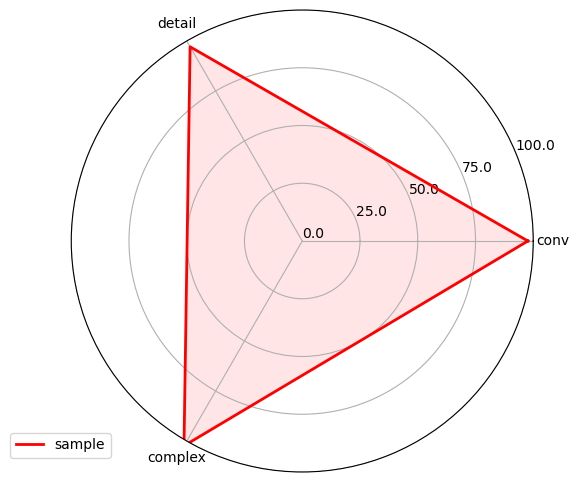

In [5]:
model_results = {
    "sample": "sample_review.json",
}
plot_result(load_model_results(model_results, num), 0, 100)